In [3]:
import tensorflow as tf
from prepare_dataset import create_dataset_from_tfrecord

## Load Dataset

In [4]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_tfrecord('dataset/qq_captcha_train.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A').cache()
test_ds = create_dataset_from_tfrecord('dataset/qq_captcha_test.tfrecords', batch_size=128, image_size=(60, 120), label_prefix='A').cache()

## Create Model

In [5]:
def CNN_multi_outputs(image_shape, n_labels=4, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')

    # conv layer 1
    x = tf.keras.layers.Conv2D(16, (3, 3))(image_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)

    # conv layer 2
    x = tf.keras.layers.Conv2D(32, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.Activation('relu')(x)

    # conv layer 3
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    # conv layer 4
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.Activation('relu')(x)

    # dense layer
    x = tf.keras.layers.Flatten()(x) # flatten

    # outputs
    labels = [tf.keras.layers.Dense(n_class, name=f'{output_label}{i}')(x) for i in range(n_labels)] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model

In [6]:
image_shape = (60, 120, 1)
n_labels = 4
n_class = 26

model = CNN_multi_outputs(image_shape, n_labels, n_class, name='cnn_multi_outputs', output_label='A')
model.summary()

Model: "cnn_multi_outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 58, 118, 16)  160         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 58, 118, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 29, 59, 16)   0           batch_normalization[0][0]        
__________________________________________________________________________________

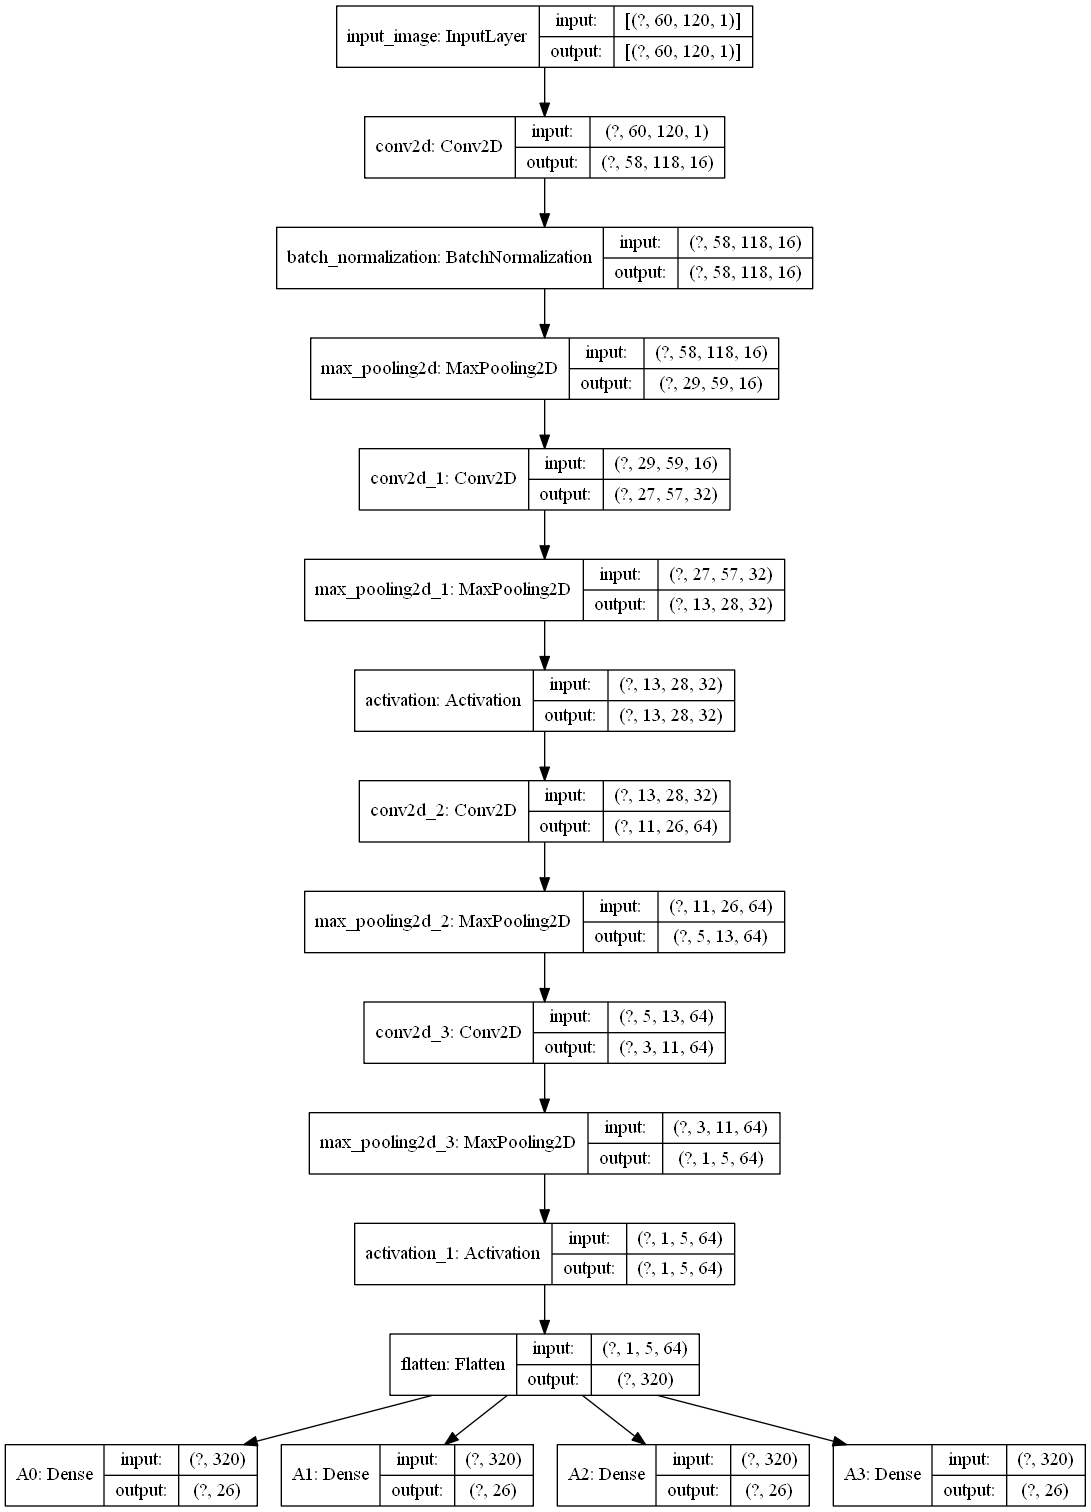

In [7]:
tf.keras.utils.plot_model(model, f'{model.name}.png', show_shapes=True)

## Train Model

In [8]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001, 0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
import os

# load model if exists
model_dir = os.path.join('models', model.name) # saved in folder with same name
if os.path.exists(model_dir):
    model = tf.keras.models.load_model(model_dir)

model.fit(train_ds, 
          epochs=100, 
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard'))])

Epoch 1/100
316/316 [==============================] - 307s 973ms/step - loss: 11.3258 - A0_loss: 2.1946 - A1_loss: 3.0282 - A2_loss: 3.0544 - A3_loss: 3.0485 - A0_accuracy: 0.2093 - A1_accuracy: 0.0975 - A2_accuracy: 0.0901 - A3_accuracy: 0.0905
Epoch 2/100
316/316 [==============================] - 301s 951ms/step - loss: 9.6398 - A0_loss: 1.6726 - A1_loss: 2.6286 - A2_loss: 2.7304 - A3_loss: 2.6081 - A0_accuracy: 0.4364 - A1_accuracy: 0.2307 - A2_accuracy: 0.2015 - A3_accuracy: 0.2419
Epoch 3/100
316/316 [==============================] - 303s 958ms/step - loss: 8.3017 - A0_loss: 1.3040 - A1_loss: 2.3177 - A2_loss: 2.4594 - A3_loss: 2.2207 - A0_accuracy: 0.5784 - A1_accuracy: 0.3233 - A2_accuracy: 0.2856 - A3_accuracy: 0.3693
Epoch 4/100
316/316 [==============================] - 287s 908ms/step - loss: 7.3309 - A0_loss: 1.0554 - A1_loss: 2.0794 - A2_loss: 2.2490 - A3_loss: 1.9470 - A0_accuracy: 0.6673 - A1_accuracy: 0.3974 - A2_accuracy: 0.3502 - A3_accuracy: 0.4547
Epoch 5/100
316

316/316 [==============================] - 287s 909ms/step - loss: 2.9776 - A0_loss: 0.2520 - A1_loss: 0.8800 - A2_loss: 1.0875 - A3_loss: 0.7581 - A0_accuracy: 0.9237 - A1_accuracy: 0.7431 - A2_accuracy: 0.6881 - A3_accuracy: 0.7868
Epoch 35/100
316/316 [==============================] - 286s 906ms/step - loss: 2.9459 - A0_loss: 0.2489 - A1_loss: 0.8715 - A2_loss: 1.0770 - A3_loss: 0.7485 - A0_accuracy: 0.9245 - A1_accuracy: 0.7460 - A2_accuracy: 0.6897 - A3_accuracy: 0.7894
Epoch 36/100
316/316 [==============================] - 266s 843ms/step - loss: 2.9247 - A0_loss: 0.2482 - A1_loss: 0.8635 - A2_loss: 1.0693 - A3_loss: 0.7437 - A0_accuracy: 0.9238 - A1_accuracy: 0.7461 - A2_accuracy: 0.6909 - A3_accuracy: 0.7905
Epoch 37/100
316/316 [==============================] - 181s 571ms/step - loss: 2.8933 - A0_loss: 0.2412 - A1_loss: 0.8560 - A2_loss: 1.0628 - A3_loss: 0.7333 - A0_accuracy: 0.9261 - A1_accuracy: 0.7489 - A2_accuracy: 0.6935 - A3_accuracy: 0.7936
Epoch 38/100
316/316 [===

In [57]:
# save the entire model
model.save(model_dir, save_format='tf')

INFO:tensorflow:Assets written to: models\cnn_multi_outputs\assets


## Test Model

In [61]:
# load model
new_model = tf.keras.models.load_model(model_dir)

In [73]:
# evaluate model: predict four labels correctly
import numpy as np

def evaluate_captcha(model, dataset):
    '''evaluate the model with test dataset:
       the prediction is good only when the four labels are predicted correctly.
    '''
    score, num = 0, 0
    for images, dict_labels in dataset.as_numpy_iterator():
        outputs = model.predict(images) # list
        for (image, *zip_labels) in zip(images, *dict_labels.values(), *outputs):
            num += 1
            labels = zip_labels[0:4] # true labels
            predict_labels = [np.argmax(label) for label in zip_labels[4:]]
            # get one score when the four predictions are correct
            for a,b in zip(labels, predict_labels):
                if a!=b: break
            else:
                score += 1
    return score / num if num else 0

In [75]:
evaluate_captcha(new_model, test_ds)

0.28145121347201585

predict labels: crdh
labels        : erdh


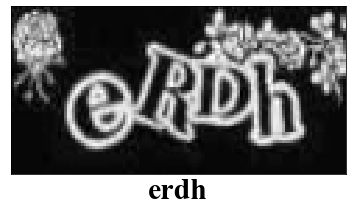

In [77]:
# prediction example
import matplotlib.pyplot as plt
%matplotlib inline

t = 111 # image t in batch

for x, y_ in test_ds.take(1):
   
    # predict labels
    y = new_model.predict(x)
    predict_labels = ''.join([chr(ord('a') + np.argmax(y[i][t])) for i in range(4)])
    print('predict labels:', predict_labels)
    
    # real labels
    labels = [y_[f'A_{i}'][t].numpy()[0] for i in range(4)]
    labels = ''.join([chr(ord('a') + c) for c in labels])
    print('labels        :',labels)
    
    # show image
    image = tf.reshape(x.numpy()[t], shape=(60, 120))
    plt.imshow(image, cmap=plt.cm.binary)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels, fontdict={'family': 'Times New Roman', 'size' : 30})
    plt.show()